# Packages Import

In [1]:
# from pyspark.sql import SparkSession
import pandas as pd
import warnings
import sys
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lead, to_date, lpad
from pyspark.sql.window import Window
sys.path.append('../src')
from data import run, load_and_concat_csv, drop_na_columns, process_data, add_y_label,lppub_column_names, lppub_column_classes
from utility import read_multiple_csv_files
warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)
print("Package Imported")

Package Imported


In [7]:
df = load_and_concat_csv("../data/raw/2015Q1.csv", lppub_column_names, lppub_column_classes)
print(len(df))

27960987


In [12]:
print(df.columns)

Index(['POOL_ID', 'LOAN_ID', 'ACT_PERIOD', 'CHANNEL', 'SELLER', 'SERVICER',
       'MASTER_SERVICER', 'ORIG_RATE', 'CURR_RATE', 'ORIG_UPB',
       ...
       'PLAN_NUMBER', 'FORBEARANCE_INDICATOR',
       'HIGH_LOAN_TO_VALUE_HLTV_REFINANCE_OPTION_INDICATOR', 'DEAL_NAME',
       'RE_PROCS_FLAG', 'ADR_TYPE', 'ADR_COUNT', 'ADR_UPB',
       'PAYMENT_DEFERRAL_MOD_EVENT_FLAG', 'INTEREST_BEARING_UPB'],
      dtype='object', length=110)


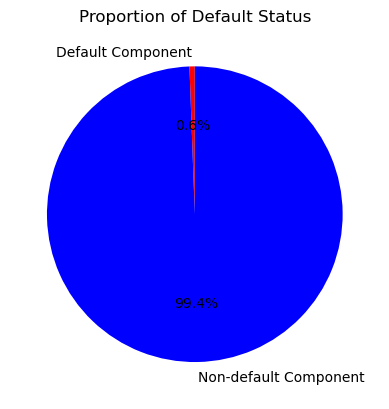

In [16]:
import matplotlib.pyplot as plt
total_count = len(df)
df['DLQ_STATUS'] = pd.to_numeric(df['DLQ_STATUS'], errors='coerce')
default_ge_3_count = len(df[df['DLQ_STATUS'] >= 3])
default_ge_3_proportion = default_ge_3_count / total_count

# Create the bar chart
categories = ['Default Component', 'Non-default Component']
proportions = [default_ge_3_proportion, 1 - default_ge_3_proportion]

colors = ['red', 'blue']  # Optional: Custom colors

# Create the pie chart
plt.pie(proportions, labels=categories, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Default Status')
plt.show()

# Data Proprocessing

## Mark Default by 4 quarters (1 year)

In [ ]:
def process_mortgage_data(input_path: str, output_path: str):
    # Initialize Spark session
    spark = SparkSession.builder.appName("MortgageDelinquency").getOrCreate()

    # Load the dataset
    df = spark.read.csv(input_path, header=True, inferSchema=True)

    # Convert 'ACT_PERIOD' from MMYYYY integer format to timestamp
    df = df.withColumn('ACT_PERIOD', lpad(df['ACT_PERIOD'].cast('string'), 6, '0'))
    df = df.withColumn('ACT_PERIOD', to_date(df['ACT_PERIOD'].cast('string'), 'MMyyyy'))
    df = df.withColumn('default_status', col('default_status').cast('int'))

    # Define a window specification to partition by LOAN_ID and order by ACT_PERIOD
    window_spec = Window.partitionBy('LOAN_ID').orderBy('ACT_PERIOD')

    # Create a column 'next_4_quarters' to look ahead for the next 8 quarters
    df = df.withColumn(
        'next_4_quarters_default',
        when(col('default_status') >= 3, 1).otherwise(0)
    )

    # Use the window spec to look at the next 4 quarters' default status
    # ???
    df = df.withColumn(
        'next_4_quarters_default',
        lead('next_4_quarters_default', 16).over(window_spec)
    )

    # Create the 'y_label' column based on next 4 quarters' default status
    df = df.withColumn('y_label', when(col('next_4_quarters_default') == 1, 1).otherwise(0))

    # Drop the intermediate 'next_4_quarters_default' column
    df = df.drop('next_4_quarters_default')
    df = df.dropna()
    
    # Convert Spark DataFrame to pandas DataFrame and save to CSV
    df.coalesce(1).write.option("header", "true").csv(output_path)

    print(f"Data processed and saved to {output_path}")


In [3]:
# # Example usage:
# input_dirc = '../data/raw/'
# processed_dirc = '../data/processed/'
# output_dirc = '../data/cleaned/'
# file_name = '2015Q1.csv'
# df = run(input_dirc+file_name, processed_dirc)
# process_mortgage_data(processed_dirc + file_name, output_dirc + file_name)

In [ ]:
input_dirc = '../data/raw/'
processed_dirc = '../data/processed/'
output_dirc = '../data/cleaned/'

# List of filenames from 2015Q1 to 2016Q4
file_names = ['2015Q1.csv', '2015Q3.csv', 
              '2016Q1.csv', '2016Q3.csv']

# Loop through the list of files and process each one
for file_name in file_names:
    # Run for each file from raw to processed
    
    # Process the mortgage data and save to cleaned directory
    process_mortgage_data(processed_dirc + file_name, output_dirc + file_name + '4_quarters')

    print(f"Processing completed for {file_name}")

In [ ]:
# input_dirc = '../data/raw/'
# processed_dirc = '../data/processed/'
# output_dirc = '../data/cleaned/'

# # List of filenames from 2015Q1 to 2016Q4
# file_names = ['2016Q3.csv']

# # Loop through the list of files and process each one
# for file_name in file_names:
#     # Run for each file from raw to processed
#     df = run(input_dirc + file_name, processed_dirc)
    
#     # Process the mortgage data and save to cleaned directory
#     process_mortgage_data(processed_dirc + file_name, output_dirc + file_name)

#     print(f"Processing completed for {file_name}")

## Mark Deafult by 8 quarters (2 years)

In [3]:
def process_mortgage_data_eight_quarters(input_path: str, output_path: str):
    # Initialize Spark session
    spark = SparkSession.builder.appName("MortgageDelinquency").getOrCreate()

    # Load the dataset
    df = spark.read.csv(input_path, header=True, inferSchema=True)

    # Convert 'ACT_PERIOD' from MMYYYY integer format to timestamp
    df = df.withColumn('ACT_PERIOD', lpad(df['ACT_PERIOD'].cast('string'), 6, '0'))
    df = df.withColumn('ACT_PERIOD', to_date(df['ACT_PERIOD'].cast('string'), 'MMyyyy'))
    df = df.withColumn('default_status', col('default_status').cast('int'))

    # Define a window specification to partition by LOAN_ID and order by ACT_PERIOD
    window_spec = Window.partitionBy('LOAN_ID').orderBy('ACT_PERIOD')

    # Create a column 'next_8_quarters' to look ahead for the next 8 quarters
    df = df.withColumn(
        'next_8_quarters_default',
        when(col('default_status') >= 3, 1).otherwise(0)
    )

    # Use the window spec to look at the next 8 quarters' default status
    # ???
    df = df.withColumn(
        'next_8_quarters_default',
        lead('next_8_quarters_default', 32).over(window_spec)
    )

    # Create the 'y_label' column based on next 8 quarters' default status
    df = df.withColumn('y_label', when(col('next_8_quarters_default') == 1, 1).otherwise(0))

    # Drop the intermediate 'next_8_quarters_default' column
    df = df.drop('next_8_quarters_default')
    df = df.dropna()
    
    # Convert Spark DataFrame to pandas DataFrame and save to CSV
    df.coalesce(1).write.option("header", "true").csv(output_path)

    print(f"Data processed and saved to {output_path}")

In [ ]:
input_dirc = '../data/raw/'
processed_dirc = '../data/processed/'
output_dirc = '../data/cleaned/'

# List of filenames from 2015Q1 to 2016Q4
file_names = ['2015Q1.csv', '2015Q3.csv', 
              '2016Q1.csv', '2016Q3.csv']

# Loop through the list of files and process each one
for file_name in file_names:
    # Run for each file from raw to processed
    
    # Process the mortgage data and save to cleaned directory
    process_mortgage_data_eight_quarters(processed_dirc + file_name, output_dirc + file_name + '8_quarters')

    print(f"Processing completed for {file_name}")

# Split Training and Testing

In [ ]:
file_paths = [
            '../data/cleaned/2015Q1.csv4_quarters/part-00000-b5c1467d-ad02-4755-887f-23da75e21c2f-c000.csv',
            '../data/cleaned/2015Q3.csv4_quarters/part-00000-882767b1-1f94-4ffd-86f3-994360725eee-c000.csv',
            '../data/cleaned/2016Q1.csv4_quarters/part-00000-ecc34829-1ad7-4cf2-9599-c5ace7fe8c56-c000.csv',
            '../data/cleaned/2016Q3.csv4_quarters/part-00000-c20c7ac4-0e92-4a8b-a9d2-3b0315407b2a-c000.csv'
            ]

df = read_multiple_csv_files(file_paths)
df.dropna(inplace=True)
df['ACT_PERIOD'] = pd.to_datetime(df['ACT_PERIOD'], errors='coerce')
train_start_date = pd.to_datetime('2015-01-01')
train_end_date = pd.to_datetime('2020-01-01')
test_start_date = pd.to_datetime('2022-01-01')
test_end_date = pd.to_datetime('2024-01-01')
train_data = df[(df['ACT_PERIOD'] >= train_start_date) & (df['ACT_PERIOD'] < train_end_date)]
test_data = df[(df['ACT_PERIOD'] >= test_start_date) & (df['ACT_PERIOD'] < test_end_date)]



In [ ]:
# Output train/test_data to CSV
train_data.to_csv('../data/final/four_quarters/train_data.csv', index=False)
test_data.to_csv('../data/final/four_quarters/test_data.csv', index=False)